# Unsupervised Learning


When we are given labels or target values associated with the training and test data, we apply supervised learning techniques to generate models that predict the target values or labels as accurately as possible.  When no such labels or target values are available, the best we can do is seek hidden structure in the data.  Unsupervised learning algorithms are designed to learn from features to categorize these unlabeled data.  

Goals for this module:
* Geometric distances
* Clustering Algorithms

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy

from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import cluster

import time
import warnings

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from itertools import cycle, islice

from sklearn.cluster import AgglomerativeClustering


## Big Picture

What are we trying to do?  Discover clusters/categories without labels.  Idea:
* samples within a cluster should be "similar"
* samples that belong to different clusters, they should be "dissimilar"

Usual steps for clustering:
1. __Data representation__: includes preparation and initial work, such as choosing the number of clusters to look for, picking what measurements to use, how many observations to process, choosing scaling and other transformations of the data
2. __Proximity Measure__: many clustering methods require a measure of distance or proximity between observations, and maybe between clusters. 
3. __Grouping__: process of partitioning the data into clusters.  This grouping can be "hard", meaning that an observation either belongs to a group, or it does not.  This grouping can also be "fuzzy" or "soft", where each sample has a degree of membership in each cluster.  The grouping can also be hierarchical, where we have a nested sequence of partitions.
4. __Data abstraction__: optional process of obtaining a simple and compact representation of the partitions, for example, this cluster could represent the set of data science students at Michigan Tech.
5. __Clusters Assessment__:are the clusters meaningful


Some natural questions that are relevant to clustering:
* how do we quantify this notion of proximity, similarity and dissimilarity?
* what algorithms should we use to cluster the data?  fast/efficient? deterministic/stochastic? 
* how many clusters do we look for?  can it be adaptively chosen?  
* do we allow very large and very small clusters?
    * which algorithms work best for a large number of samples?
    * which algorithms work best when there are many classes?
* how do we quantify how the performance of our clustering/grouping?



## Geometric Distance

We need some measure of distance between samples. If the features are continuous variables, a popular choice is the Euclidean distance.  Let $\vec{x}$ and $\vec{y}$ be two observations, each consisting of $D$ continuous features, i.e., $\vec{x},\vec{y}\in\mathbb{R}^D$.  Then, the Euclidean distance is defined as 
\begin{align}
d(\vec{x},\vec{y}) = \|\vec{x} - \vec{y}\|_2 =  \left( \sum_{i=1}^D (x_i - y_i)^2 \right)^{1/2}
\end{align}
We could also weight the distances using:
\begin{align}
d(\vec{x},\vec{y}) = \|\vec{x} - \vec{y}\|_{w,2} =  \left( \sum_{i=1}^D w_i(x_i - y_i)^2 \right)^{1/2}
\end{align}

Other options include the Manhattan distance,
\begin{align}
d(\vec{x},\vec{y}) = \|\vec{x} - \vec{y}\|_1 = \sum_{i=1}^D |x_i - y_i|
\end{align}
or the maximum distance,
\begin{align}
d(\vec{x},\vec{y}) = \|\vec{x} - \vec{y}\|_\infty = \max_i |x_i - y_i|
\end{align}

Some properties of distance measures:
* $d(\vec{x},\vec{y}) \ge 0$
* $d(\vec{x},\vec{x}) = 0 $
* $d(\vec{x},\vec{y}) = d(\vec{y},\vec{x})$
* $d(\vec{x},\vec{y}) \le d(\vec{x},\vec{z}) + d(\vec{z},\vec{y})$ (Triangle Inequality)

With $N$ samples, one can generate a distance matrix, $D$, which is of size $n\times n$, and whose elements $d_{ij}$ correspond to the distance between sample $\vec{x}_i$ and sample $\vec{x}_j$, i.e. $d_{ij} = d(\vec{x}_i,\vec{x}_j)$.

If a distance measure was available, one can measure similarity by using a kernel.  Most commonly, the Gaussian kernel is used,
\begin{align}
  s(\vec{x},\vec{y}) = \exp \left(-\gamma\,d(\vec{x},\vec{y}) \right)
\end{align}

Why do we call this a similarity measure?  If $d(\vec{x},\vec{y}) = 0$, then $s(\vec{x},\vec{y})$, the similarity, is equal to 1 (the maximum similarity possible). If $d(\vec{x},\vec{y})$ is very large, then the similarity is very small.  One can choose whether to use the distance measure or the similarity measure to try and cluster the data. 


### Data Scaling 

Note, scaling the data (either by pre-processing, or by using a weighted distance measure) can have significant impact on the results.  

Consider the following simple example of four people where we have their age (in years) and their height (in feet).

In [2]:
population = {'height (feet)': [5, 6, 5, 6], 'age': [25, 25, 30, 30]}
df = pd.DataFrame(data = population)
df

,height (feet),age
0,5,25
1,6,25
2,5,30
3,6,30


A quick scatterplot of the data.

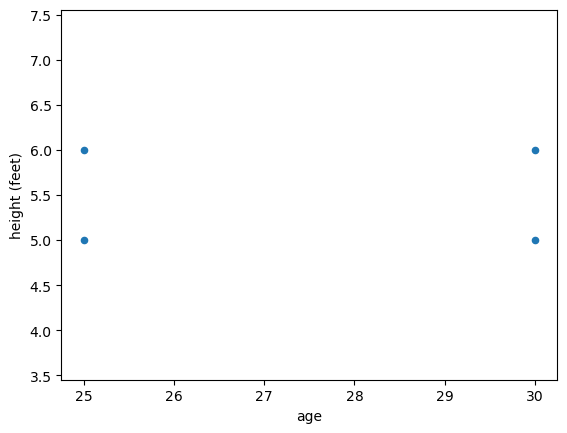

In [3]:
ax1 = df.plot.scatter(x='age', y = "height (feet)")
_ = ax1.axis('equal')

Looking at this plot, might lead us to the conclusion that there are two clusters, and we should group people with the same age together.  However, if we lived outside the US, we would normally report the height in centimeters.  

Lets create a new column in our data frame, that give the person's height in centimeters and generate a new scatter plot.

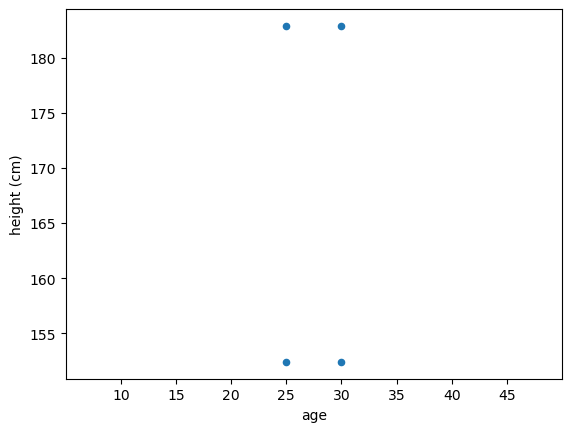

In [4]:
df["height (cm)"] = df["height (feet)"]*12*2.54
df

ax1 = df.plot.scatter(x='age', y = "height (cm)")
_ = ax1.axis('equal')

Now, we might conclude that there are two clusters, and we should group people with the same height together. This should serve as a warning that scaling (weighting) plays a crucial role in the generation of the clusters.  There is no single "correct" answer as to whether to scale or not.  Some observations though:
* if variables are not scaled, the variable with the largest range has the most weight in the distance.
* scaling gives every variable equal weight
* don't scale if the units are the same for all features, e.g., every feature is some measurement in pounds.
* scaling is okay if the variables measure different units (e.g., age in years, height in cm).  

What do we do if some of the data is categorical (a.k.a. mixed data?)  
* we could transform the categorical data into a continuous equivalent...  This is tricky because scaling might unfairly favor a feature.  
* can use an alternative formulation for similarity: most popular one is the Gower dissimilarity metric. The categorical variables are expressed in binary columns based on which category they fall into.  Each variable is then standardized (subtract mean, divide by standard deviation).  The categorical columns are further divided by $\sqrt{2}$ to compensate for their 0/1 encoding.  
* The last two pages of these notes http://www.econ.upf.edu/~michael/stanford/maeb5.pdf gives a nice example of how to compute the Gower dissimilarity.

## Metrics



### Rand Index
Before diving into clustering algorithms,we need to understand how to compare clustering results since there are no labels to measure accuracy of our clustering.  Suppose we have $n$ samples in a set $S$, and 
* clustering method \#1 partitions $S$ into $r$ subsets, $X = \{X_1, \ldots, X_r\}$,
* clustering method \#2 partitions $S$ into  $s$ subsets, $Y = \{Y_1, \ldots, Y_s\}$.

Define the following:

* a, the number of pairs of elements in S that are in the same set in X and in the same set in Y
* b, the number of pairs of elements in S that are in different sets in X and in different sets in Y
* c, the number of pairs of elements in S that are in the same set in X and in different sets in Y
* d, the number of pairs of elements in S that are in different sets in X and in the same set in Y.

The Rand index, R, is:
$ R = \frac{a+b}{a+b+c+d} = \frac{a+b}{{n \choose 2 }} $


This is easier seen in an example.  
* Suppose we have six samples in our set: $\{a, b, c, d, e, f\}$. 
* Clustering method 1 (CM1) forms three clusters; 
    * $\{a,b\}$ are in group 0, 
    * $\{c,d\}$ are in group 1, 
    * $\{e,f\}$ are in group 2
* Clustering method 2 (CM2) forms two clusters; 
    * $\{a,b,c\}$ are in group 0
    * $\{d,e,f\}$ are in in group 1
    
How do these two clustering methods compare?  What is the Rand index for these two clustering results?

To compute the Rand index, we need to exhaustively check every unordered pair.  There are 15 unordered pairs from the set of six samples:
$\{a, b\}, \{a, c\}, \{a, d\}, \{a, e\}, \{a, f\}, \{b, c\}, \{b, d\}, \{b, e\}, \{b, f\}, \{c, d\}, \{c, e\}, \{c, f\}, \{d, e\}, \{d, f\}$, and $\{e, f\}$.

* Of these 15 pairs, which ones are in the same clusters proposed by CM1 and CM2?
In this example, only two: $\{a, b\}$ and $\{e, f\}$, so one variable for the rand score is $a=2$.
* Of these 15 pairs, which ones are not grouped together by the two clustering methods?
$\{a, d\}, \{a, e\}, \{a, f\}, \{b, d\}, \{b, e\}, \{b, f\}, \{c, e\}$, and $\{c, f\}$, 
so the second variable for the rand score is $b=8$.

Thus, the rand score is : 

$ R = \frac{a+b}{{n \choose 2 }} = \frac{10}{6 \choose 2} = \frac{10}{15} = 0.667$


Python's `scikit-learn` actually does not have a built-in method for computing the Rand index.  Instead, there are functions to compute an adjusted rand score.  The adjusted Rand index was designed to account for chance grouping of elements.  Specifically,

* when given two clusterings with random labels, the adjusted rand index will return a value close to 0.

* when the number of clusters increases, the adjusted rand index will return a number close to 1.

How is the adjusted rand index (AR) computed?

\begin{align}
\text{ARI} = \frac{ \sum_{ij} {n_{ij} \choose 2} - \left[ \sum_i {a_i \choose 2} \sum_j {b_j \choose 2} \right] / {n \choose 2}}{ \frac{1}{2} \left[ \sum_i {a_i \choose 2} + \sum_j {b_j \choose 2} \right] - \left[ \sum_i {a_i \choose 2} \sum_j {b_j \choose 2} \right] / {n \choose 2}} 
\end{align}

We can create a contingency table for the two clustering methods, where entries in the table are $n_{ij}$ and row and columns sums are $a_1, ..., a_r$ and $b_1, ..., b_s$ respectively. 

| X \ Y |  Y_1  | Y_2  | $a_i$ |
|-------|-------|------|-------| 
| X_1   |   2   |  0   |  2    |
| X_2   |   1   |  1   |  2    | 
| X_3   |   0   |  2   |  2    | 
| $b_j$ |   3   |  3   |  --- | 

There is a built in function in scikit-learn that computes the adjusted rand score.

In [5]:
# from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score([0, 0, 1, 1, 2, 2], [0, 0, 0, 1, 1, 1])

0.24242424242424243

### V-Measure

Suppose we had the "ground-truth", i.e., true clustering labels for our data.  Then, we can measure the "homogeneity" criterion, and the completeness criterion.
* A clustering result satisfies **homogeneity** if all of its clusters contain only samples which are members of the same ground-truth class.
* A clustering result satisfies **completeness** if all the samples that are members of a ground-truth cluster are samples of the same cluster generated by the clustering.

In [6]:
# from sklearn import metrics

# format: homogeneity_score(ground_truth, clustering)
print ("homogeneity score = %g\n" % 
       metrics.homogeneity_score([0, 0, 1, 1], [0, 0, 1, 1]))
print ("completeness score = %g\n" % 
       metrics.completeness_score([0, 0, 1, 1], [0, 0, 1, 1]))


homogeneity score = 1

completeness score = 1



In [7]:
# What if we just relabel the clusters, group 0 becomes group 1 and vice-versa
print ("homogeneity score = %g\n" % 
       metrics.homogeneity_score([0, 0, 1, 1], [1, 1, 0, 0]))
print ("completeness score = %g\n" % 
       metrics.completeness_score([0, 0, 1, 1], [1, 1, 0, 0]))

homogeneity score = 1

completeness score = 1



In [8]:
print ("homogeneity score = %g\n" % 
       metrics.homogeneity_score([0, 0, 1, 1], [0, 0, 1, 2]))
print ("completeness score = %g\n" % 
       metrics.completeness_score([0, 0, 1, 1], [0, 0, 1, 2]))

homogeneity score = 1

completeness score = 0.666667



In [9]:
print ("homogeneity score = %g\n" % 
       metrics.homogeneity_score([0, 0, 1, 1], [0, 1, 2, 3]))
print ("completeness score = %g\n" % 
       metrics.completeness_score([0, 0, 1, 1], [0, 1, 2, 3]))

homogeneity score = 1

completeness score = 0.5



In [10]:
print ("homogeneity score = %g\n" % 
       metrics.homogeneity_score([0, 0, 1, 1], [0, 1, 0, 1]))
print ("completeness score = %g\n" % 
       metrics.completeness_score([0, 0, 1, 1], [0, 1, 0, 1]))

homogeneity score = 0

completeness score = 0



In [11]:
print ("homogeneity score = %g\n" % 
       metrics.homogeneity_score([0, 0, 1, 1], [0, 0, 0, 0]))
print ("completeness score = %g\n" % 
       metrics.completeness_score([0, 0, 1, 1], [0, 0, 0, 0]))

homogeneity score = 0

completeness score = 1



The *V-measure* is the harmonic mean between homogeneity and completeness:

  $v = 2 * (homogeneity * completeness) / (homogeneity + completeness)$

Questions:
* will a permutation of the class or cluster label values change the score value in any way?
* Is the metric symmetric wrt the switching label_true with label_pred?

**Advantages of using the V-measure**

* Bounded scores: 0.0 is bad clustering, 1.0 is a perfect score.

* Intuitive interpretation: clustering with bad V-measure can be qualitatively analyzed in terms of homogeneity and completeness to better feel what ‘kind’ of mistakes is done by the assignment.

* No assumption is made on the cluster structure

**Drawbacks**

* The V-measure is not normalized with regards to random labeling: this means that depending on the number of samples, clusters and ground truth classes, a completely random labeling will not always yield the same values for homogeneity, completeness and hence V-measure. In particular random labeling won’t yield zero scores especially when the number of clusters is large.

+ This problem can safely be ignored for a large number of samples

+ These metrics require knowledge of the ground truth classes.

### Silhouette Coefficient

If the ground-truth cluster is not available, we can compute the silhouette coefficient. This Silhouette Coefficient is calculated using 
* $a$, the mean intra-cluster distance between elements in a cluster. The smaller the value, the better the cluster.
* $b$, the mean nearest cluster distance for each sample.

The Silhouette Coefficient for a sample is:
\begin{align}
\frac{b-a}{\max{(a,b)}} 
\end{align}

Question:
* what is a good silhouette value?
* what is a poor silhouette value?

We can use a silhouette value to estimate how many clusters to use for $k$-means clustering.

# Clustering

There are two families of clustering techniques we will discuss:
* Partitional algorithms: Start with a random partition and refine it iteratively.
* Hierarchical algorithms -- Agglomerative (bottom-up) or top-down approaches

Lets first look at partition algorithms.  Partitional algorithms can be divided in two groups:
* Hard partition algorithms, such as *K-means*, assign a unique cluster value to each element in the feature space.
* Soft partition algorithms, such as *Mixture of Gaussians*, can be viewed as density estimators and assign a confidence or probability to each point in the space.

In order to build our intuition about clustering, we will start with the $K$-means algorithm.

##  K-means algorithm

1. Given, $K$, number of clusters, select initial cluster centers.
2. For each of the $N$ data samples,assigning them to the nearest cluster centroids (e.g. the center of gravity or mean).
3. Compute the new $K$ cluster centers
4. Repeat last two steps, until some convergence criterion is met. 

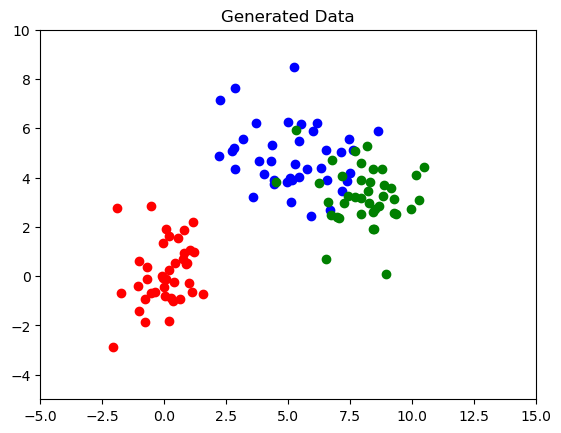

In [12]:
#Create some data
MAXN=40
X = np.concatenate([1.25*np.random.randn(MAXN,2), 5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,3]+1.2*np.random.randn(MAXN,2)])

#Just for visualization purposes, create the labels of the 3 distributions
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.ylim(-5, 10)
plt.xlim(-5, 15)
_ = plt.title('Generated Data')

We'll apply scikit-learn toolkit to cluster the data into 3 clusters.

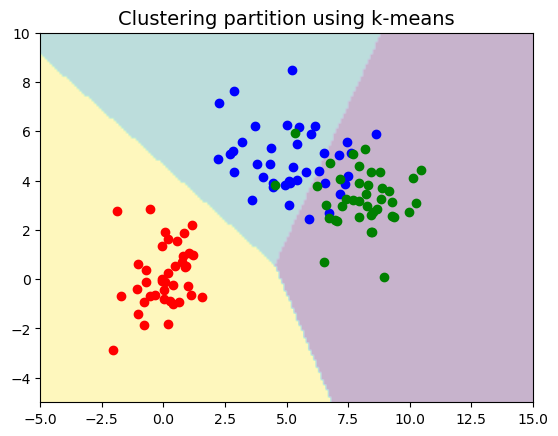

In [13]:
# from sklearn import cluster

K=3 # Assuming to be 3 clusters!

clf = cluster.KMeans(init='random', n_init='auto', n_clusters=K)
clf.fit(X)

# instead of assigning our data to clusters, we'll plot the 
# phase space: lay a grid, and predict which cluster each grid
# node belongs to. 

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()] 

Z=clf.predict(data)
plt.imshow(Z.reshape(sz), interpolation='bilinear', origin='lower', 
           extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=K-1)
plt.title('Clustering partition using k-means', size=14)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.ylim(-5, 10)
plt.xlim(-5, 15)
fig = plt.gcf()

### Exercise

Since we have the true labels for this toy problem, compute the completeness score, the homogeneity score, and the v-measure score, summarizing your observation.

Some math behind the $K$-means algorithm...  the $K$-means algorithm seeks centroids that minimize the "inertia", a.k.a., the within-cluster sum-of-squares:
\begin{align}
  \text{Inertia}=\displaystyle\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)|
\end{align}

Some quirks:
* Inertia makes the assumption that clusters are convex and isotropic (WHY?). Hence, $K$-means performs terribly on elongated clusters, or manifolds with irregular shapes.

* Convergence to global minimum? Given enough time, K-means will always converge, but to a local minimum.

* The $k$-means algorithm requires the number of clusters to be specified a-priori. 

* The $k$-means algorithm scales well to a large number of samples, and has been used across a large range of application areas in many different fields.


In fact, the computation is often done several times, with different random initial partitioning of the samples.  One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='kmeans++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization.

In [14]:
from sklearn import metrics

clf = cluster.KMeans(n_clusters=K, init='k-means++',  random_state=0, 
                     max_iter=300, n_init=10) 
clf.fit(X) 

print('Final evaluation of the clustering:')
print('Inertia: %.2f' %  clf.inertia_ )
print('Adjusted_rand_score %.2f' % metrics.adjusted_rand_score(y.ravel(),clf.labels_))
print('Homogeneity %.2f' %  metrics.homogeneity_score(y.ravel(),clf.labels_))
print('Completeness %.2f' %  metrics.completeness_score(y.ravel(),clf.labels_))
print('V_measure %.2f' %  metrics.v_measure_score(y.ravel(), clf.labels_))
print('Silhouette %.2f' %  metrics.silhouette_score(X, clf.labels_,metric='euclidean'))

Final evaluation of the clustering:
Inertia: 309.22
Adjusted_rand_score 0.73
Homogeneity 0.75
Completeness 0.76
V_measure 0.75
Silhouette 0.56


In [15]:
# lets run the k-means algorithm on a bunch of diferent generated data, a la
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

# import time
# import warnings

# from sklearn import datasets
# from sklearn.preprocessing import StandardScaler

# from itertools import cycle, islice

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

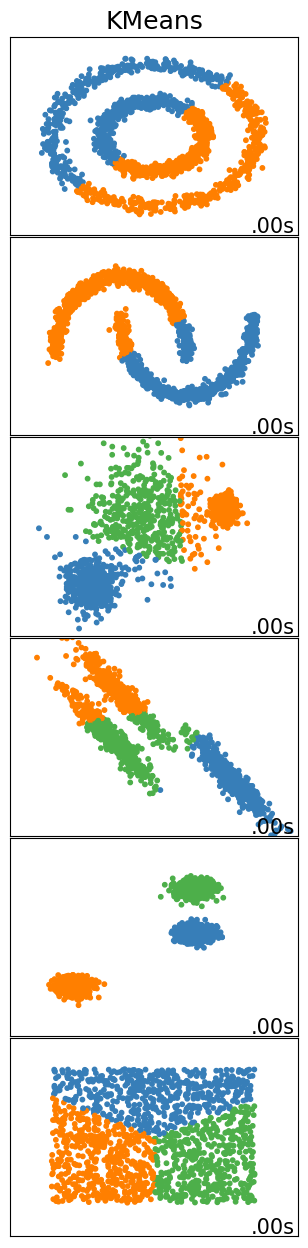

In [16]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(3, 12.5))

plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])


    # ============
    # Create cluster objects
    # ============
    two_means = cluster.KMeans(n_clusters=params['n_clusters'], n_init='auto')

    clustering_algorithms = (
        ('KMeans', two_means),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Hierarchical clustering

Hierarchical clustering builds nested clusters by *merging or splitting* them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the *leaves* being the clusters with only one sample. This approach is popular because of its interpretability - the algorithm returns a *tree*, which shows similarity among the samples. *Partitioning* is computed by selecting a cut on that tree at a certain level. 

Two different approaches:
1. Bottom-Up agglomerative clustering

    * Starts with each sample data in a separate cluster.
    
    * Then, repeatedly joins the closest pair of clusters.
    
    * Stop when there is only one cluster.
    
    * history of merging forms a binary tree or hierarchy.  
    

2. Top-Down divisive clustering

    * Start with all the data in a single cluster.
    
    * Consider every possible way to divide the cluster into two. Choose the best division.
    
    * Recursively operate on both sides.

Lets look at the agglomerative clustering (bottom-up) approach.  The natural question is: how do we measure the similarity of two clusters?  Book gives three different criterion, resulting in three different metrics for cluster merging:
1. Maximum (complete) linkage minimize distance between observations of pairs of clusters.
2. Average linkage averages similarity between members (minimizes the average of the distances between all observations of pairs of clusters)
3. Ward linkage minimizes the sum of squared distances within all clusters.  (variance-minimizing approach)

Lets see how these three linkages work.

In [17]:
# Generate some data 
MAXN1 =500
MAXN2 =400
MAXN3 =300
X1 = np.concatenate ([2.25*np.random.randn(MAXN1,2),4+1.7* np.random.randn (MAXN2 ,2)])
X1 = np.concatenate ([X1,[8,3]+1.9* np.random.randn(MAXN3 ,2)])
y1 = np.concatenate ([ np.ones ((MAXN1,1)),2* np.ones((MAXN2,1))])
y1 = np.concatenate ([y1,3* np.ones((MAXN3,1))]).ravel()
y1 = np.int_(y1)
labels_y1=['+','*','o']
colors=['r','g', 'b']

Apply agglomerative clustering using the different linkages:

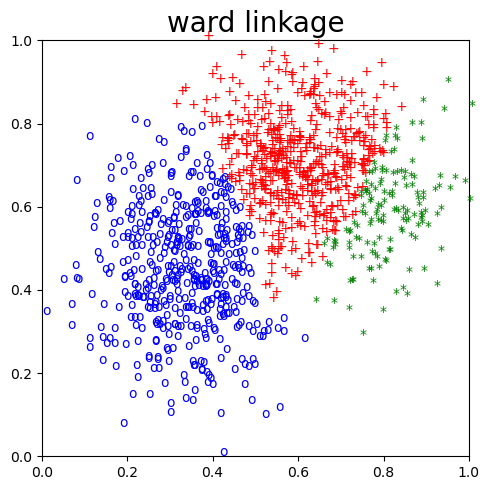

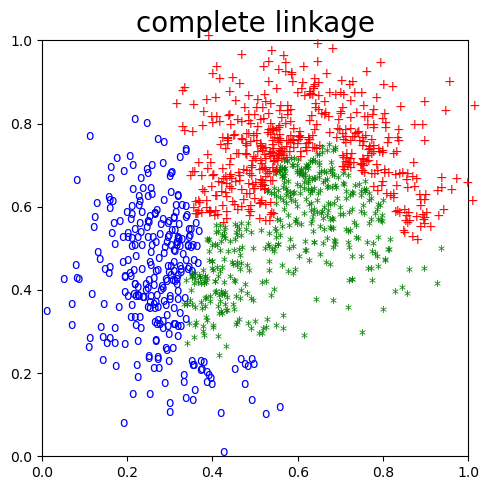

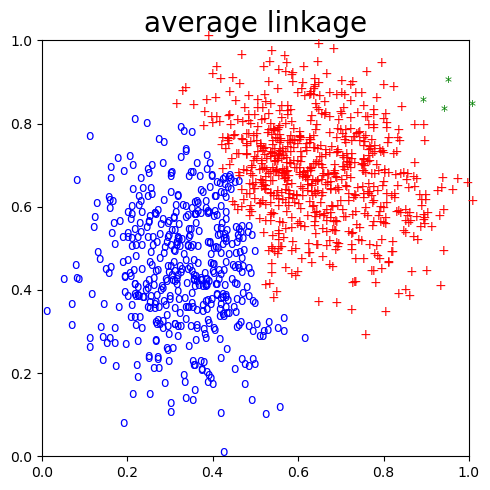

In [18]:
# from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'complete', 'average'):
    clustering = AgglomerativeClustering(linkage=linkage,n_clusters =3)
    clustering.fit(X1)
    ypred = clustering.fit_predict(X1)

    
    x_min , x_max = np.min (X1, axis =0) , np.max (X1,axis =0)
    X1 = (X1 - x_min ) / ( x_max - x_min )
    fig = plt.figure ()
    fig.set_size_inches((5,5))
    for i in range (X1.shape [0]) :
        plt.text(X1[i,0],X1[i,1],labels_y1[ypred[i]-1],color=colors[ypred[i]-1])
    plt.title ("%s linkage" % linkage,size =20)
    plt.tight_layout()
    
plt.show()